# Agent Evaluation

In this section, we will explore the evaluation of agentic systems. Agentic systems are complex constructs consisting of multiple sub-components. In Lab 3, we examined a simple singleton agent orchestrating between two tools. Lab 4 demonstrated a more sophisticated multi-layer agentic system with a top-level router agent coordinating multiple agentic sub-systems.

One direct implication of the interdependent and potentially nested nature of agentic systems is that evaluation can occur at both macro and micro levels. This means that either the entire system as a whole is being evaluated (macro view) or each individual sub-component is assessed (micro view). For nested systems, this applies to every level of abstraction.

Typically, evaluation begins at the macro level. In many cases, positive evaluation results at the macro level indicate sufficient agent performance. If macro-level performance evaluation proves insufficient or yields poor results, micro-level evaluation can help decompose the performance metrics and attribute results to specific sub-components.

In this lab, we will first explore macro-level agent performance evaluation. Then, we will evaluate tool usage as a lower-level task. To maintain focus on the evaluation process, we will keep the agentic system simple by utilizing the singleton agent composed in Lab 3.

## Agent Setup

As covered in the previous section, we will reuse the Agent we built in Lab 3. This agent has access to tools designed to help find vacation destinations. You'll be able to interact with the agent by asking questions, observe it utilizing various tools, and engage in meaningful conversations.

Let's begin by installing the required packages.

In [1]:
%pip install -U langchain-community langgraph langchain-chroma langchain_aws pandas ragas==0.2.3 pypdf rapidfuzz

  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.3/389.3 kB 52.8 MB/s eta 0:00:00
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.3
    Uninstalling pydantic-2.7.3:
      Successfully uninstalled pydantic-2.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

### Util functions part 1 - importing singleton agent

To maintain a clean and focused approach in this notebook, we have moved the agent creation logic to a module in `utils.py`. The `create_agent` function replicates the agent creation process we developed in Lab 3, with an additional boolean parameter `enable_memory` that controls whether memory checkpointing is enabled.

In [4]:
from utils import create_agent
agent_executor = create_agent(enable_memory=True)

The ```create_agent``` function returns a ```CompiledStateGraph``` object that represents the Agent from Lab 3's scenario. 
Now, let's proceed to visualize this graph.

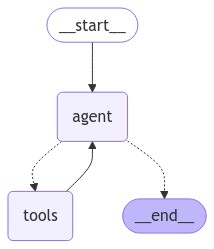

In [5]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

Now, we are ready to proceed with evaluating our agent!


## Agent Evaluation with RAGAS

In this section, we will explore sophisticated methods for evaluating agentic systems using the RAGAS framework. Building upon our previous work with the vacation destination agent from Lab 3, we'll implement both high-level (macro) and low-level (micro) evaluation approaches.

RAGAS provides specialized tools for evaluating Large Language Model (LLM) applications, with particular emphasis on agentic systems. We'll focus on two key evaluation dimensions:

1. [High-Level Agent Accuracy](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/agents/#agent-goal-accuracy):
   - Agent Goal Accuracy (with reference): Measures how well the agent achieves specified goals by comparing outcomes against annotated reference responses
   - Agent Goal Accuracy (without reference): Evaluates goal achievement by inferring desired outcomes from user interactions

2. [Low-Level Tool Usage](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/agents/#tool-call-accuracy):
   - Tool Call Accuracy: Assesses the agent's ability to identify and utilize appropriate tools by comparing actual tool calls against reference tool calls
   - The metric ranges from 0 to 1, with higher values indicating better performance

This structured evaluation approach allows us to comprehensively assess our vacation destination agent's performance, both at the system level and the component level. By maintaining our focus on the singleton agent from Lab 3, we can clearly demonstrate these evaluation techniques without the added complexity of nested agent systems.

Let's proceed with implementing these evaluation methods to analyze our agent's effectiveness in handling vacation-related queries and tool interactions.

### Util functions part 2 - Message Format Conversion

Our singleton agent is built using the LangChain/LangGraph framework. LangChain defines several [message objects](https://python.langchain.com/v0.1/docs/modules/model_io/chat/message_types/) to handle different types of communication within an agentic system. According to the LangChain documentation, these include:

- HumanMessage: This represents a message from the user. Generally consists only of content.
- AIMessage: This represents a message from the model. This may have additional_kwargs in it - for example tool_calls if using Amazon Bedrock tool calling.
- ToolMessage: This represents the result of a tool call. In addition to role and content, this message has a `tool_call_id` parameter which conveys the id of the call to the tool that was called to produce this result.

Similarly, our evaluation framework RAGAS implements its own message wrapper objects:

- [HumanMessage](https://docs.ragas.io/en/latest/references/evaluation_schema/?h=aimessage#ragas.messages.HumanMessage): Represents a message from a human user.
- [AIMessage](https://docs.ragas.io/en/latest/references/evaluation_schema/?h=aimessage#ragas.messages.AIMessage): Represents a message from an AI.
- [ToolMessage](https://docs.ragas.io/en/latest/references/evaluation_schema/?h=aimessage#ragas.messages.ToolMessage): Represents a message from a tool.
- [ToolCall](https://docs.ragas.io/en/latest/references/evaluation_schema/?h=aimessage#ragas.messages.ToolCall):  Represents a tool invocation with name and arguments (typically contained within an `AIMessage` when tool calling is used)

To evaluate the conversation flow generated by the LangGraph agent, we need to convert between these two message type systems. For convenience, we've implemented the `convert_message_langchian_to_ragas` function in the `utils.py` module. This function handles the conversion process seamlessly. You can import it along with the message wrapper objects, which are assigned appropriate aliases to ensure cross-compatibility between the frameworks.

In [6]:
from utils import create_agent, convert_message_langchain_to_ragas

from langchain_core.messages import HumanMessage as LCHumanMessage
from langchain_core.messages import AIMessage as LCAIMessage
from langchain_core.messages import ToolMessage as LCToolMessage


from ragas.messages import Message as RGMessage
from ragas.messages import HumanMessage as RGHumanMessage
from ragas.messages import AIMessage as RGAIMessage
from ragas.messages import ToolMessage as RGToolMessage
from ragas.messages import ToolCall as RGToolCall

Since we typically evaluate multi-turn conversations, we will implement a helper function capable of handling arrays of messages. This function will enable us to process and analyze multiple conversational exchanges seamlessly.

In [7]:
def convert_messages(response):
    return list(map((lambda m: convert_message_langchain_to_ragas(m)), response['messages']))

For the evaluation, we will examine three distinct scenarios that represent different user profiles:

1. **Stephen Walker - The User with Travel History**
   * A 20-year-old resident of Honolulu
   * Exists in our travel history database
   * Previous travel records enable precise, personalized recommendations
   * Expected to have a smooth, seamless conversation flow

2. **Jane Doe - The First-Time User**
   * No prior interaction with our travel recommendation system
   * Requires the agent to rely on creative recommendation strategies
   * Will test the system's ability to gather information and provide relevant suggestions
   * May experience a slightly more exploratory conversation flow

3. **Homer Simpson - The Distracted User**
   * No previous travel history in our system
   * Exhibits difficulty maintaining focused conversation
   * Will challenge the agent's ability to handle divergent discussions
   * Tests the system's capability to guide and redirect conversations effectively

These scenarios will help us evaluate our travel agent's performance across different user types and interaction patterns. Let's proceed with executing these conversation flows to assess our system's effectiveness.

In [8]:
config = {"configurable": {"thread_id": "1"}}
agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    "My name is Stephen Walker, please suggest me a good vacation destination.",
                )
            ]
        },
        config,
    )
response_stephen = agent_executor.invoke(
        {
            "messages": [
                ("user", "I'm interested in more information about the location you suggested. Please provide me with a summary of what a travel guide would suggest!")
            ]
        },
        config,
    )
response_stephen

{'messages': [HumanMessage(content='My name is Stephen Walker, please suggest me a good vacation destination.', additional_kwargs={}, response_metadata={}, id='5cd89e6c-bfd2-4e4d-b3d2-17fdc2d98dac'),
  AIMessage(content=[{'type': 'text', 'text': 'Okay, let me first check which destinations you have already visited by invoking the compare_and_recommend_destination tool.'}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'name': 'Stephen Walker'}, 'id': 'tooluse_NAN7fvOwTt-D3APIAnOqFw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'dbbb70bb-2bd3-4d75-9948-6e3b2a0f71f6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 05 Nov 2024 23:29:09 GMT', 'content-type': 'application/json', 'content-length': '444', 'connection': 'keep-alive', 'x-amzn-requestid': 'dbbb70bb-2bd3-4d75-9948-6e3b2a0f71f6'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 1465}}, id='run-cc09d3a9-1ca8-42ee-bec5-7f1f34d93a22-0', tool_c

In [9]:
config = {"configurable": {"thread_id": "2"}}
agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    "My name is Jane Doe, please suggest me a good vacation destination.",
                )
            ]
        },
        config,
    )
response_jane = agent_executor.invoke(
        {
            "messages": [
                ("user", "I'm interested in more information about the location you suggested. Please provide me with a summary of what a travel guide would suggest!")

            ]
        },
        config,
    )
response_jane

{'messages': [HumanMessage(content='My name is Jane Doe, please suggest me a good vacation destination.', additional_kwargs={}, response_metadata={}, id='70c82dac-0fe5-44dc-94c3-d732ac267007'),
  AIMessage(content=[{'type': 'text', 'text': 'Okay, let me first check which destinations you have already visited:'}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'name': 'Jane Doe'}, 'id': 'tooluse_bgDVMg3ORhGSY68X99CsKQ'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'e123a1fc-ad01-47c6-a799-31debafce531', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 05 Nov 2024 23:29:47 GMT', 'content-type': 'application/json', 'content-length': '383', 'connection': 'keep-alive', 'x-amzn-requestid': 'e123a1fc-ad01-47c6-a799-31debafce531'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 2108}}, id='run-634cb439-e543-4dad-a4c1-0dc39a24451c-0', tool_calls=[{'name': 'compare_and_recommend_destination', 'args': {'name'

In [10]:
config = {"configurable": {"thread_id": "3"}}
agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    "My name is Homer Simpson, please suggest me a good vacation destination.",
                )
            ]
        },
        config,
    )
agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    "How can I brew beer over there? Which sort of hops is best suited for this?"
                )
            ]
        },
        config,
    )
agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    "What is the best local beer brand in this specific place?"
                )
            ]
        },
        config,
    )
response_confused_homer = agent_executor.invoke(
        {
            "messages": [
                ("user", "I'm confused. Why does my beer taste bitter?")
            ]
        },
        config,
    )
response_confused_homer

{'messages': [HumanMessage(content='My name is Homer Simpson, please suggest me a good vacation destination.', additional_kwargs={}, response_metadata={}, id='a2981173-b888-4138-876e-b4e14146a425'),
  AIMessage(content=[{'type': 'text', 'text': 'Okay, let me check where you have already traveled to avoid recommending those places.'}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'name': 'Homer Simpson'}, 'id': 'tooluse_WeJIjb78QDGL4IQwqtdS7g'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '58af7686-1697-479b-88fd-d7362e1a40fc', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 05 Nov 2024 23:30:18 GMT', 'content-type': 'application/json', 'content-length': '405', 'connection': 'keep-alive', 'x-amzn-requestid': '58af7686-1697-479b-88fd-d7362e1a40fc'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 2458}}, id='run-2332a08b-75d1-4daf-b80f-6326fdd225b8-0', tool_calls=[{'name': 'compare_and_recommend_de

Now that we have collected the agent conversations from Stephen, Jane, and Homer, we can proceed with converting them from LangChain's message format into RAGAS message format. For this conversion, we will utilize the previously defined `convert_messages` function.

In [11]:
rg_messages_stephen = convert_messages(response_stephen)
rg_messages_stephen

[HumanMessage(content='My name is Stephen Walker, please suggest me a good vacation destination.', metadata=None, type='human'),
 AIMessage(content='Okay, let me first check which destinations you have already visited by invoking the compare_and_recommend_destination tool.', metadata=None, type='ai', tool_calls=[ToolCall(name='compare_and_recommend_destination', args={'id': 'tooluse_NAN7fvOwTt-D3APIAnOqFw', 'query': 'Stephen Walker'})]),
 ToolMessage(content='User not found in the travel database.', metadata={'tool_name': 'compare_and_recommend_destination', 'tool_call_id': 'tooluse_NAN7fvOwTt-D3APIAnOqFw'}, type='tool'),
 AIMessage(content="Since you are not found in the travel database, it seems you haven't traveled much before. Let me query the travel guide to suggest a good destination for you based on some general interests.", metadata=None, type='ai', tool_calls=[ToolCall(name='travel_guide', args={'id': 'tooluse_iEOFXlzMQICvI45pzOrLFQ', 'query': 'beach vacation destinations'})])

In [12]:
rg_messages_confused_homer = convert_messages(response_confused_homer)
rg_messages_confused_homer

[HumanMessage(content='My name is Homer Simpson, please suggest me a good vacation destination.', metadata=None, type='human'),
 AIMessage(content='Okay, let me check where you have already traveled to avoid recommending those places.', metadata=None, type='ai', tool_calls=[ToolCall(name='compare_and_recommend_destination', args={'id': 'tooluse_WeJIjb78QDGL4IQwqtdS7g', 'query': 'Homer Simpson'})]),
 ToolMessage(content='User not found in the travel database.', metadata={'tool_name': 'compare_and_recommend_destination', 'tool_call_id': 'tooluse_WeJIjb78QDGL4IQwqtdS7g'}, type='tool'),
 AIMessage(content="Since I don't have any record of your previous travel destinations, let me suggest a popular vacation spot based on some typical interests:", metadata=None, type='ai', tool_calls=[ToolCall(name='travel_guide', args={'id': 'tooluse_8KHKya6RQIWJO6_Nl9uDHw', 'query': 'family-friendly beach destinations'})]),
 ToolMessage(content='Travel Guide: Newport\nGenerated by Llama3.1 405B\n \nNestled

In [13]:
rg_messages_jane = convert_messages(response_jane)
rg_messages_jane

[HumanMessage(content='My name is Jane Doe, please suggest me a good vacation destination.', metadata=None, type='human'),
 AIMessage(content='Okay, let me first check which destinations you have already visited:', metadata=None, type='ai', tool_calls=[ToolCall(name='compare_and_recommend_destination', args={'id': 'tooluse_bgDVMg3ORhGSY68X99CsKQ', 'query': 'Jane Doe'})]),
 ToolMessage(content='User not found in the travel database.', metadata={'tool_name': 'compare_and_recommend_destination', 'tool_call_id': 'tooluse_bgDVMg3ORhGSY68X99CsKQ'}, type='tool'),
 AIMessage(content='Since you are a new user in our system and have not traveled before based on our records, I will try to recommend a good vacation destination for you.\n\nTo suggest a suitable place, it would be helpful if you could provide some information about your interests and preferences. Are you looking for a beach vacation, a city break, an adventure trip, or something else? Do you prefer warm or cold weather destinations?

With our conversation flows now properly formatted, we can proceed with the actual evaluation phase.

### Agent Goal Accuracy

Agent Goal Accuracy is a metric designed to evaluate how well an LLM identifies and achieves user goals. It's a binary metric where 1 indicates successful goal achievement and 0 indicates failure. The evaluation is performed using an evaluator LLM, which needs to be defined and configured before metric calculation.

The Agent Goal Accuracy metric comes in two distinct variants:

- Agent Goal Accuracy without reference
- Agent Goal Accuracy with reference

Before exploring these variants in detail, we need to establish our evaluator LLM. For this purpose, we will utilize Anthropic Claude 3 Sonnet as our judge. While this is our choice in this lab, the selection of the evaluator LLM always needs to be adjusted based on specific use cases and requirements.

In [14]:
import boto3
from ragas.llms import LangchainLLMWrapper
from langchain_aws import ChatBedrockConverse

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

judge_llm = LangchainLLMWrapper(ChatBedrockConverse(
    model="anthropic.claude-3-sonnet-20240229-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
))

#### Agent Goal Accuracy Without Reference
AgentGoalAccuracyWithoutReference operates without a predefined reference point. Instead, it evaluates the LLM's performance by inferring the desired outcome from the human interactions within the workflow. This approach is particularly useful when explicit reference outcomes are not available or when the success criteria can be determined from the conversation context.

To evaluate this metric, we first encapsulate our agent conversation in a `MultiTurnSample` object, which is designed to handle multi-turn agentic conversations within the RAGAS ecosystem. Next, we initialize an `AgentGoalAccuracyWithoutReference` object to implement our evaluation metric. Finally, we configure the judge LLM and execute the evaluation across our three agent conversations.

In [15]:
from ragas.dataset_schema import  MultiTurnSample
from ragas.messages import HumanMessage,AIMessage,ToolMessage,ToolCall
from ragas.metrics import AgentGoalAccuracyWithoutReference


sample_stephen = MultiTurnSample(user_input=rg_messages_stephen)

sample_jane = MultiTurnSample(user_input=rg_messages_jane)

sample_confused_homer = MultiTurnSample(user_input=rg_messages_confused_homer)


scorer = AgentGoalAccuracyWithoutReference()
scorer.llm = judge_llm

In [16]:
await scorer.multi_turn_ascore(sample_stephen)

0.0

In [17]:
await scorer.multi_turn_ascore(sample_jane)

0.0

In [18]:
await scorer.multi_turn_ascore(sample_confused_homer)

0.0

#### Agent Goal Accuracy With Reference
AgentGoalAccuracyWithReference requires two key inputs: the user_input and a reference outcome. This variant evaluates the LLM's performance by comparing its achieved outcome against an annotated reference that serves as the ideal outcome. The metric is calculated at the end of the workflow by assessing how closely the LLM's result matches the predefined reference outcome.

To evaluate this metric, we will follow a similar approach. First, we encapsulate our agent conversation within a `MultiTurnSample` object, which is specifically designed to manage multi-turn agent conversations in the RAGAS framework. For this evaluation, we need to provide an annotated reference that will serve as a benchmark for the judge's assessment. We then initialize an `AgentGoalAccuracyWithReference` object to implement our evaluation metric. Finally, we set up the judge LLM and conduct the evaluation across all three agent conversations to measure their performance against our defined criteria.

In [19]:
from ragas.dataset_schema import  MultiTurnSample
from ragas.messages import HumanMessage,AIMessage,ToolMessage,ToolCall
from ragas.metrics import AgentGoalAccuracyWithReference


sample_stephen = MultiTurnSample(user_input=rg_messages_stephen,
    reference="Provide detailed information about suggested holiday destination.")

sample_jane = MultiTurnSample(user_input=rg_messages_jane,
    reference="Provide detailed information about suggested holiday destination.")

sample_confused_homer = MultiTurnSample(user_input=rg_messages_confused_homer,
    reference="Provide detailed information about suggested holiday destination.")

scorer = AgentGoalAccuracyWithReference()
scorer.llm = judge_llm

In [20]:
await scorer.multi_turn_ascore(sample_stephen)

1.0

In [ ]:
await scorer.multi_turn_ascore(sample_jane)

In [ ]:
await scorer.multi_turn_ascore(sample_confused_homer)

Let's analyze the results and their relationship to each persona's interaction patterns with the agent. We encourage you to discuss these findings with your workshop group to gain deeper insights. Keep in mind that agent conversations are dynamic and non-deterministic, meaning evaluation results may vary across different runs. 

However, certain patterns emerge:
- Stephen's and Jane's conversations typically achieve a 1.0 rating due to their focused and goal-oriented approach
- Homer's interactions, characterized by chaotic and divergent patterns without a consistent objective, are more likely to receive a 0.0 rating

### Tool Call accuracy

ToolCallAccuracy is a metric that can be used to evaluate the performance of the LLM in identifying and calling the required tools to complete a given task. This metric needs user_input and reference_tool_calls to evaluate the performance of the LLM in identifying and calling the required tools to complete a given task. The metric is computed by comparing the reference_tool_calls with the Tool calls made by the AI. Therefore, in this particular scenario, there is no need for an evaluator LLM. The values range between 0 and 1, with higher values indicating better performance.

To evaluate the tool call accuracy metric, we follow a different process. First, we encapsulate our agent conversation within a `MultiTurnSample` object, which is specifically designed to handle multi-turn agent conversations in the RAGAS framework. This evaluation requires a set of annotated reference tool calls that serve as a benchmark for assessment. Next, we initialize a `ToolCallAccuracy` object to implement our evaluation metric. While the default behavior compares tool names and arguments using exact string matching, this may not always be optimal, particularly when dealing with natural language arguments. Therefore, we set the `arg_comparison_metric` to `NonLLMStringSimilarity`, which employs a semantic distance metric to determine the relevance of retrieved contexts more effectively.

In [ ]:
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import  MultiTurnSample
from ragas.messages import HumanMessage,AIMessage,ToolMessage,ToolCall
from ragas.metrics._string import NonLLMStringSimilarity



sample_stephen = MultiTurnSample(
    user_input=rg_messages_stephen,
    reference_tool_calls=[
        ToolCall(name="compare_and_recommend_destination", args={"name": "Stephen Walker"}),
        ToolCall(name="travel_guide", args={"query": "Key West"}),
    ]
)

sample_jane = MultiTurnSample(
    user_input=rg_messages_jane,
    reference_tool_calls=[
        ToolCall(name="compare_and_recommend_destination", args={"name": "Jane Doe"}),
        ToolCall(name="travel_guide", args={"query": "Key West"}),
    ]
)

sample_homer = MultiTurnSample(
    user_input=rg_messages_confused_homer,
    reference_tool_calls=[
        ToolCall(name="compare_and_recommend_destination", args={"name": "Jane Doe"}),
        ToolCall(name="travel_guide", args={"query": "Key West"}),
    ]
)

scorer = ToolCallAccuracy()
scorer.arg_comparison_metric = NonLLMStringSimilarity()

In [ ]:
await scorer.multi_turn_ascore(sample_stephen)

In [ ]:
await scorer.multi_turn_ascore(sample_jane)

In [ ]:
await scorer.multi_turn_ascore(sample_homer)

Let's analyze the results and their relationship to each persona's interaction patterns with the agent. We encourage you to discuss these findings with your workshop group to gain deeper insights. Keep in mind that agent conversations are dynamic and non-deterministic, meaning evaluation results may vary across different runs.

However, certain patterns emerge:
- Stephen's conversations typically achieve a very high rating due to his focused and goal-oriented approach and the fact that he can be found in the travel database - this helps matching all tool call arguments
- Jane's conversations typically achieve a high but slightly lower rating. While her conversation is focused and goal-oriented, she is not in the travel database. This causes the first tool call suggestions to be less deterministic, reducing the likelihood of Florida-based recommendations
- Homer's interactions achieve very low scores since they are characterized by chaotic and divergent patterns. This makes it highly unlikely to match the correct tool call sequence

Congratulations! You have successfully completed this lab and the entire workshop. Thank you for your active participation in today's session. If you have any questions or need clarification on any topics covered, please don't hesitate to reach out to the instructors.

**Your feedback is valuable to us! Before you leave, we kindly ask you to take a moment to scan the QR code and share your thoughts about the workshop. Your insights will help us enhance future sessions and provide an even better learning experience.**